In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import pickle
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [2]:
df_train = pd.read_excel('Personal Calling List Train.xlsx')
df_test = pd.read_excel('Personal Calling List Test.xlsx')

In [3]:
df_train = df_train.drop(['prediction_val', 'Probability_Score'], axis = 1)
df_test = df_test.drop(['prediction_val', 'Probability_Score'], axis = 1)

In [4]:
df_train.head()

,CURRENT_DELINQUENCY_STATUS,NUM_OF_DR_TRANS_MONTH5,NUM_OF_CR_TRANS_MONTH5,MONTH5_MONTH4_INCREASED_TRANSACTIONS_PERCENTAGE,MONTH5_MONTH4_HIGHEST_DEBIT_TRANSACTIONS,PRINCIPALOUTSTANDING,CR_TOT_3_MONTH_AVG,TOTAL_TRANSACTIONS_6_MONTH_AVG,INCREASED_EARNINGS_PERCENTAGE_6_MONTH_AVG,HIGHEST_CREDIT_TRANSACTIONS_6_MONTH_AVG,HIGHEST_CREDIT_TRANSACTIONS_PERCENTAGE_3_MONTH_AVG,HIGHEST_DEBIT_TRANSACTIONS_PERCENTAGE_6_MONTH_AVG,Occupation|AGENT,Occupation|CLERK,Occupation|DRIVER,Occupation|MANAGER,"Occupation|SECURITY,CARETAKERS,MESSENGERS,WAITERS",Occupation|SELF-EMPLOYED,Occupation|STUDENT,Occupation|TEACHER,Occupation|UNEMPLOYED,Occupation|others,Primary_City|FALMOUTH,Primary_City|KINGSTON,Primary_City|LUCEA,Primary_City|MANDEVILLE,Primary_City|MAY PEN,Primary_City|MONTEGO BAY,Primary_City|N/A,Primary_City|OLD HARBOUR,Primary_City|PORTMORE,Primary_City|SPANISH TOWN,Primary_City|others,Primary_City|None,Primary_Parish|CLARENDON,Primary_Parish|HANOVER,Primary_Parish|KINGSTON,Primary_Parish|MANCHESTER,Primary_Parish|ST ANDREW,Primary_Parish|ST ANN,Primary_Parish|ST CATHERINE,Primary_Parish|ST ELIZABETH,Primary_Parish|ST JAMES,Primary_Parish|WESTMORELAND,Primary_Parish|others,Primary_Parish|None
0,1,-0.598880,-0.344876,1.372685,-0.030944,-0.257803,-0.451644,-0.219491,0.011802,-0.182279,-5.809618e-02,-0.164827,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,1.308174,0.697767,-0.293297,-0.128282,-0.223014,0.671407,0.967138,0.011802,0.488579,-5.806971e-02,0.024931,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,-0.598880,-0.344876,-0.293297,-0.030633,1.464740,0.942281,-0.615034,0.011802,0.020723,7.480146e-01,-0.164685,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,1.308174,1.740411,0.817357,-0.030938,0.450065,0.776598,0.769366,0.011802,0.207845,-5.807974e-02,-0.164754,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,-0.598880,-0.344876,-0.293297,-0.030698,0.109370,-0.562544,-0.377708,0.011802,0.066229,8.553261e-16,-0.163354,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6406 entries, 0 to 6405
Data columns (total 46 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   CURRENT_DELINQUENCY_STATUS                          6406 non-null   int64  
 1   NUM_OF_DR_TRANS_MONTH5                              6406 non-null   float64
 2   NUM_OF_CR_TRANS_MONTH5                              6406 non-null   float64
 3   MONTH5_MONTH4_INCREASED_TRANSACTIONS_PERCENTAGE     6406 non-null   float64
 4   MONTH5_MONTH4_HIGHEST_DEBIT_TRANSACTIONS            6406 non-null   float64
 5   PRINCIPALOUTSTANDING                                6406 non-null   float64
 6   CR_TOT_3_MONTH_AVG                                  6406 non-null   float64
 7   TOTAL_TRANSACTIONS_6_MONTH_AVG                      6406 non-null   float64
 8   INCREASED_EARNINGS_PERCENTAGE_6_MONTH_AVG           6406 non-null   float64
 9

In [6]:
X_train = df_train.drop('CURRENT_DELINQUENCY_STATUS', axis = 1).copy()
X_train.shape

(6406, 45)

In [7]:
y_train = df_train['CURRENT_DELINQUENCY_STATUS'].copy()

In [8]:
X_test = df_test.drop('CURRENT_DELINQUENCY_STATUS', axis = 1).copy()

In [9]:
y_test = df_test['CURRENT_DELINQUENCY_STATUS'].copy()

In [10]:
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

In [11]:
target = 'CURRENT_DELINQUENCY_STATUS'
features = [x for x in list(df_train.columns) if x != target]

### Tuning the Hyperparameters

In [12]:
# Create function
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=len(features), activation=activation))
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=50)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [13]:
params_nn2 ={
    'neurons': (100, 300),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.001, 1),
    'batch_size':(50, 500),
    'epochs':(20, 200),
    'layers1':(1,3),
    'layers2':(1,3),
    'dropout':(0,1),
    'dropout_rate':(0,0.5)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=20, n_iter=5)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.5139   |  5.51     |  126.1    |  0.4361   |  0.3846   |  73.16    |  1.298    |  1.045    |  0.4208   |  147.7    |  2.364    |
|  2        |  0.5701   |  8.916    |  157.0    |  0.08119  |  0.3348   |  131.8    |  1.549    |  1.932    |  0.1192   |  114.8    |  6.305    |
|  3        |  0.5707   |  7.146    |  428.3    |  0.8152   |  0.4955   |  123.9    |  2.628    |  1.843    |  0.02842  |  190.8    |  0.7373   |
|  4        |  0.5707   |  7.355    |  364.0    |  0.5653   |  0.1371   |  199.7    |  1.276    |  2.231    |  0.4856   |  181.0    |  5.095    |
|  5        |  0.5648   |  2.905    |  230.2    |  0.319    |  0.4736   |  185.4    |  2.628    |  1.068    |  0.9434   |  2

In [14]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'tanh',
 'batch_size': 483,
 'dropout': 0.14781137906345743,
 'dropout_rate': 0.4534065634832967,
 'epochs': 110,
 'layers1': 2,
 'layers2': 2,
 'learning_rate': 0.17827321334780982,
 'neurons': 273,
 'optimizer': <keras.optimizer_v2.adadelta.Adadelta at 0x1da342420a0>}

In [15]:
 def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(params_nn_['neurons'], input_dim=len(features), activation=params_nn_['activation']))
        for i in range(params_nn_['layers1']):
            nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
        if params_nn_['dropout'] > 0.5:
            nn.add(Dropout(params_nn_['dropout_rate'], seed=123))
        for i in range(params_nn_['layers2']):
            nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
        if params_nn_['dropout'] > 0.5:
            nn.add(Dropout(params_nn_['dropout_rate'], seed=123))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=params_nn_['optimizer'], metrics=['accuracy'])
        return nn
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=nn_cl_fun, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'], verbose=0)
nn.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=1)

Epoch 1/110
14/14 [==============================] - 1s 22ms/step - loss: 0.6253 - accuracy: 0.6597 - val_loss: 0.5795 - val_accuracy: 0.7160
Epoch 2/110
14/14 [==============================] - 0s 11ms/step - loss: 0.5840 - accuracy: 0.7176 - val_loss: 0.5763 - val_accuracy: 0.7185
Epoch 3/110
14/14 [==============================] - 0s 11ms/step - loss: 0.5810 - accuracy: 0.7195 - val_loss: 0.5746 - val_accuracy: 0.7147
Epoch 4/110
14/14 [==============================] - 0s 12ms/step - loss: 0.5789 - accuracy: 0.7181 - val_loss: 0.5700 - val_accuracy: 0.7166
Epoch 5/110
14/14 [==============================] - 0s 12ms/step - loss: 0.5784 - accuracy: 0.7212 - val_loss: 0.5762 - val_accuracy: 0.7085
Epoch 6/110
14/14 [==============================] - 0s 12ms/step - loss: 0.5767 - accuracy: 0.7212 - val_loss: 0.5695 - val_accuracy: 0.7197
Epoch 7/110
14/14 [==============================] - 0s 12ms/step - loss: 0.5752 - accuracy: 0.7226 - val_loss: 0.5681 - val_accuracy: 0.7216
Epoch 

14/14 [==============================] - 0s 12ms/step - loss: 0.5313 - accuracy: 0.7374 - val_loss: 0.5634 - val_accuracy: 0.6792
Epoch 59/110
14/14 [==============================] - 0s 12ms/step - loss: 0.5317 - accuracy: 0.7387 - val_loss: 0.5407 - val_accuracy: 0.7291
Epoch 60/110
14/14 [==============================] - 0s 12ms/step - loss: 0.5303 - accuracy: 0.7393 - val_loss: 0.5388 - val_accuracy: 0.7328
Epoch 61/110
14/14 [==============================] - 0s 13ms/step - loss: 0.5267 - accuracy: 0.7418 - val_loss: 0.5634 - val_accuracy: 0.7247
Epoch 62/110
14/14 [==============================] - 0s 12ms/step - loss: 0.5306 - accuracy: 0.7381 - val_loss: 0.5453 - val_accuracy: 0.7260
Epoch 63/110
14/14 [==============================] - 0s 12ms/step - loss: 0.5285 - accuracy: 0.7412 - val_loss: 0.5398 - val_accuracy: 0.7247
Epoch 64/110
14/14 [==============================] - 0s 12ms/step - loss: 0.5299 - accuracy: 0.7406 - val_loss: 0.5417 - val_accuracy: 0.7253
Epoch 65/110

In [16]:
nn.model.summary()

Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_745 (Dense)           (None, 273)               12558     
                                                                 
 dense_746 (Dense)           (None, 273)               74802     
                                                                 
 dense_747 (Dense)           (None, 273)               74802     
                                                                 
 dense_748 (Dense)           (None, 273)               74802     
                                                                 
 dense_749 (Dense)           (None, 273)               74802     
                                                                 
 dense_750 (Dense)           (None, 1)                 274       
                                                                 
Total params: 312,040
Trainable params: 312,040
Non-

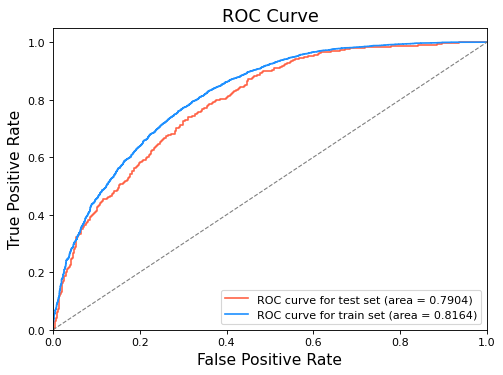

In [17]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Get predictions

train_set_preds = [round(x[0]) for x in nn.predict(X_train)]
test_set_preds = [round(x[0]) for x in nn.predict(X_test)]

train_preds = [x[0] for x in nn.predict_proba(X_train)]
test_preds = [x[0] for x in nn.predict_proba(X_test)]

# Get AUC and ROC
train_tpr, train_fpr, train_thresholds = roc_curve(y_train, train_preds)
test_tpr, test_fpr, test_thresholds = roc_curve(y_test, test_preds)
train_roc_auc = auc(train_fpr, train_tpr)
test_roc_auc = auc(test_fpr, test_tpr)

# Visualize ROC curve
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(test_fpr,
         test_tpr,
         color='tomato',
         label='ROC curve for test set (area = %0.4f)' % test_roc_auc)
plt.plot(train_fpr,
         train_tpr,
         color='dodgerblue',
         label='ROC curve for train set (area = %0.4f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc="lower right")

plt.show()

In [18]:
print(f'Confusion Matrix for Train Data:\n {confusion_matrix(y_train, train_set_preds)}')
print('\n')
print(f'Confusion Matrix for Test Data:\n {confusion_matrix(y_test, test_set_preds)}')

Confusion Matrix for Train Data:
 [[3284  372]
 [1246 1504]]


Confusion Matrix for Test Data:
 [[799 114]
 [316 373]]


In [19]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, auc

from sklearn.metrics import recall_score, precision_score, f1_score

print(f'accuracy score:', accuracy_score(y_train, train_set_preds))
print('Recall:', recall_score(y_train, train_set_preds, average = 'macro'))
print('Precision:', precision_score(y_train, train_set_preds, average = 'macro'))
print('f1_Score:', f1_score(y_train, train_set_preds, average = 'macro'))
print(f'classification report score: \n {classification_report(y_train, train_set_preds)}')

accuracy score: 0.7474242897283796
Recall: 0.7225792719315696
Precision: 0.7633252846458343
f1_Score: 0.7262916271482667
classification report score: 
               precision    recall  f1-score   support

           0       0.72      0.90      0.80      3656
           1       0.80      0.55      0.65      2750

    accuracy                           0.75      6406
   macro avg       0.76      0.72      0.73      6406
weighted avg       0.76      0.75      0.74      6406



In [20]:
print(f'accuracy score:', accuracy_score(y_test, test_set_preds))
print('Recall:', recall_score(y_test, test_set_preds, average = 'macro'))
print('Precision:', precision_score(y_test, test_set_preds, average = 'macro'))
print('f1_Score:', f1_score(y_test, test_set_preds, average = 'macro'))
print(f'classification report score: \n {classification_report(y_test, test_set_preds)}')

accuracy score: 0.731585518102372
Recall: 0.7082506036813834
Precision: 0.7412528429756632
f1_Score: 0.7111610916555972
classification report score: 
               precision    recall  f1-score   support

           0       0.72      0.88      0.79       913
           1       0.77      0.54      0.63       689

    accuracy                           0.73      1602
   macro avg       0.74      0.71      0.71      1602
weighted avg       0.74      0.73      0.72      1602



In [21]:
gini_test = 2*roc_auc_score(y_test, nn.predict_proba(X_test)[:, 1])-1
print(f"Gini score for Personal Loan {gini_test}")

Gini score for Personal Loan 0.5808106419609032


In [22]:
gini_train = 2*roc_auc_score(y_train, nn.predict_proba(X_train)[:, 1])-1
print(f"Gini score for Personal Loan {gini_train}")

Gini score for Personal Loan 0.6327579073005769
